In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 20455.80it/s]


In [3]:
#dataset[:10]
human_vocab
#inv_machine_vocab
#machine_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34,
 '<unk>': 35,
 '<pad>': 36}

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: saturday may 9 1998
Target date: 1998-05-09

Source after preprocessing (indices): [29 13 30 31 28 16 13 34  0 24 13 34  0 12  0  4 12 12 11 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [7]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a"
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis 
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a,s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e.
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies.
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas,a])

    
    return context

In [8]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
# For the purposes of passing the automatic grader
# please do not modify this global variable.  This will be corrected once the automatic grader is also updated.
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense(len(machine_vocab), activation=softmax)

In [9]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Define your pre-attention Bi-LSTM. 
    a = Bidirectional(LSTM(n_a, return_sequences= True))(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
    
        #  Perform one step of the attention mechanism to get back the context vector at step t 
        context = one_step_attention(a, s)
        
        # Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state]
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        #  Append "out" to the "outputs" list 
        outputs.append(out)
    
    # Create model instance taking three inputs and returning the list of outputs.
    model = Model(inputs=[X,s0,c0], outputs= outputs)
    

    return model

In [10]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

In [12]:

opt = Adam(lr = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics=['accuracy'])


In [13]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [16]:
model.fit([Xoh, s0, c0], outputs, epochs=3, batch_size=100)
#its going to be slow and loss will be high

Epoch 1/3
10000/10000 [==============================] - 6s 566us/step - loss: 0.8097 - dense_3_loss: 0.2427 - dense_3_accuracy: 0.9944 - dense_3_accuracy_1: 0.9973 - dense_3_accuracy_2: 0.9833 - dense_3_accuracy_3: 0.9876 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9808 - dense_3_accuracy_6: 0.9799 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9454 - dense_3_accuracy_9: 0.9520
Epoch 2/3
10000/10000 [==============================] - 6s 556us/step - loss: 0.0560 - dense_3_loss: 0.0060 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9992 - dense_3_accuracy_3: 0.9984 - dense_3_accuracy_4: 1.0000 - dense_3_accuracy_5: 0.9973 - dense_3_accuracy_6: 0.9993 - dense_3_accuracy_7: 1.0000 - dense_3_accuracy_8: 0.9992 - dense_3_accuracy_9: 0.9993
Epoch 3/3
10000/10000 [==============================] - 6s 569us/step - loss: 0.0413 - dense_3_loss: 0.0037 - dense_3_accuracy: 1.0000 - dense_3_accuracy_1: 1.0000 - dense_3_accuracy_2: 0.9995 - dense_3_ac

In [15]:
model.load_weights('models/model.h5')
#pre trained


In [17]:
EXAMPLES = [ "8th of february brr1919", '5 April 09', '21thst of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.expand_dims(source, axis=0)
    print(source.shape)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output),"\n")

(1, 30, 37)
source: 8th of february brr1919
output: 1919-02-08 

(1, 30, 37)
source: 5 April 09
output: 2009-04-05 

(1, 30, 37)
source: 21thst of August 2016
output: 2016-08-21 

(1, 30, 37)
source: Tue 10 Jul 2007
output: 2007-07-10 

(1, 30, 37)
source: Saturday May 9 2018
output: 2018-05-09 

(1, 30, 37)
source: March 3 2001
output: 2001-03-03 

(1, 30, 37)
source: March 3rd 2001
output: 2001-03-03 

(1, 30, 37)
source: 1 March 2001
output: 2001-03-01 



In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

<Figure size 432x288 with 0 Axes>

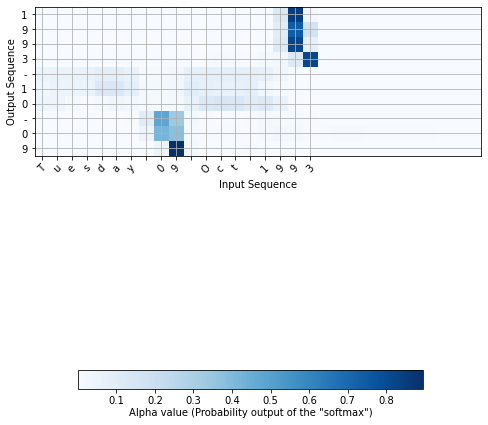

In [19]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);

In [20]:
#can increase probability by increasing data manually